In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [2]:
#!wget https://raw.githubusercontent.com/JasonMorris1/CSE151_Tesla_Stock_Prediction/main/tsla_2014_2023.csv
df = pd.read_csv('tsla_2014_2023.csv')
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df = df.drop(columns=['open', 'high', 'low']) # not sure why we do this
#note I didn't drop other columns
df.head()







,date,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,next_day_close,year
0,2014-01-02,10.006667,92826000,55.344071,54.440118,-37.373644,15.213422,9.682107,9.820167,10.494240,9.674284,0.169472,9.740800,0.395333,0.402641,0.447550,9.970667,2014
1,2014-01-03,9.970667,70425000,53.742629,53.821521,-81.304471,17.481130,9.652800,9.826069,10.495693,9.680190,0.162623,9.776167,0.239333,0.379311,0.432677,9.800000,2014
2,2014-01-06,9.800000,80416500,46.328174,50.870410,-123.427544,-37.824708,9.629467,9.825047,10.496740,9.682577,0.141790,9.797900,0.344000,0.374267,0.426343,9.957333,2014
3,2014-01-07,9.957333,75511500,53.263037,53.406750,-84.784651,-20.779431,9.597747,9.830235,10.503407,9.688051,0.136402,9.837900,0.343334,0.369848,0.420414,10.085333,2014
4,2014-01-08,10.085333,92448000,58.368660,55.423026,60.799662,43.570559,9.573240,9.840239,10.511147,9.695964,0.140837,9.870167,0.329334,0.364060,0.413908,9.835333,2014


In [5]:

#df = df.drop(columns=['sma_50', 'sma_100', 'rsi_7', 'ema_50', 'atr_7'], axis=1)

df_train1=df[(df.year<20222) & (df.year>2019)]
df_test1=df[(df.year >=2022)]

x_date = df['date']
df_train = df_train1.drop(['date','year','next_day_close'],axis=1)
df_test = df_test1.drop(['date','year','next_day_close'],axis=1)



In [6]:
#SCALE THE DATA
scalar = MinMaxScaler()
df_train_scaled = scalar.fit_transform(df_train)
#df_test_scaled = scalar.fit_transform(df_test)

type(df_train_scaled)






numpy.ndarray

In [7]:
X_train = []
y_train = []


for i in range(60, df_train.shape[0]):
    X_train.append(df_train_scaled[i-60: i])
    y_train.append(df_train_scaled[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [8]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 15)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

c:\Users\jason\miniconda3\envs\pythonProject1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 60)         │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,561 (709.22 KB)

 Trainable params: 181,561 (709.22 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
regressor.fit(X_train, y_train, epochs=30, batch_size = 64)
regressor.save('newLtsm.keras')

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0227
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0215
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0212
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0237
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0209
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.0226
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0198
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0223
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0229
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0216
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0188
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0216
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0224
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0200
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - lo

In [16]:
past_60 = df_train.tail(60)

dt = pd.concat([past_60, df_test], ignore_index=True)

In [17]:
data_test = scalar.fit_transform(dt)
print(data_test.shape)


(561, 15)


In [18]:
X_test = []
y_test = []

for i in range(60, data_test.shape[0]):
    X_test.append(data_test[i-60:i])
    y_test.append(data_test[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((501, 60, 15), (501,))

In [19]:
y_pred = regressor.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


In [20]:
scale = 1/scalar.scale_[0]
print(scale)
y_pred = y_pred*scale
y_test = y_test*scale

291.82666800000004


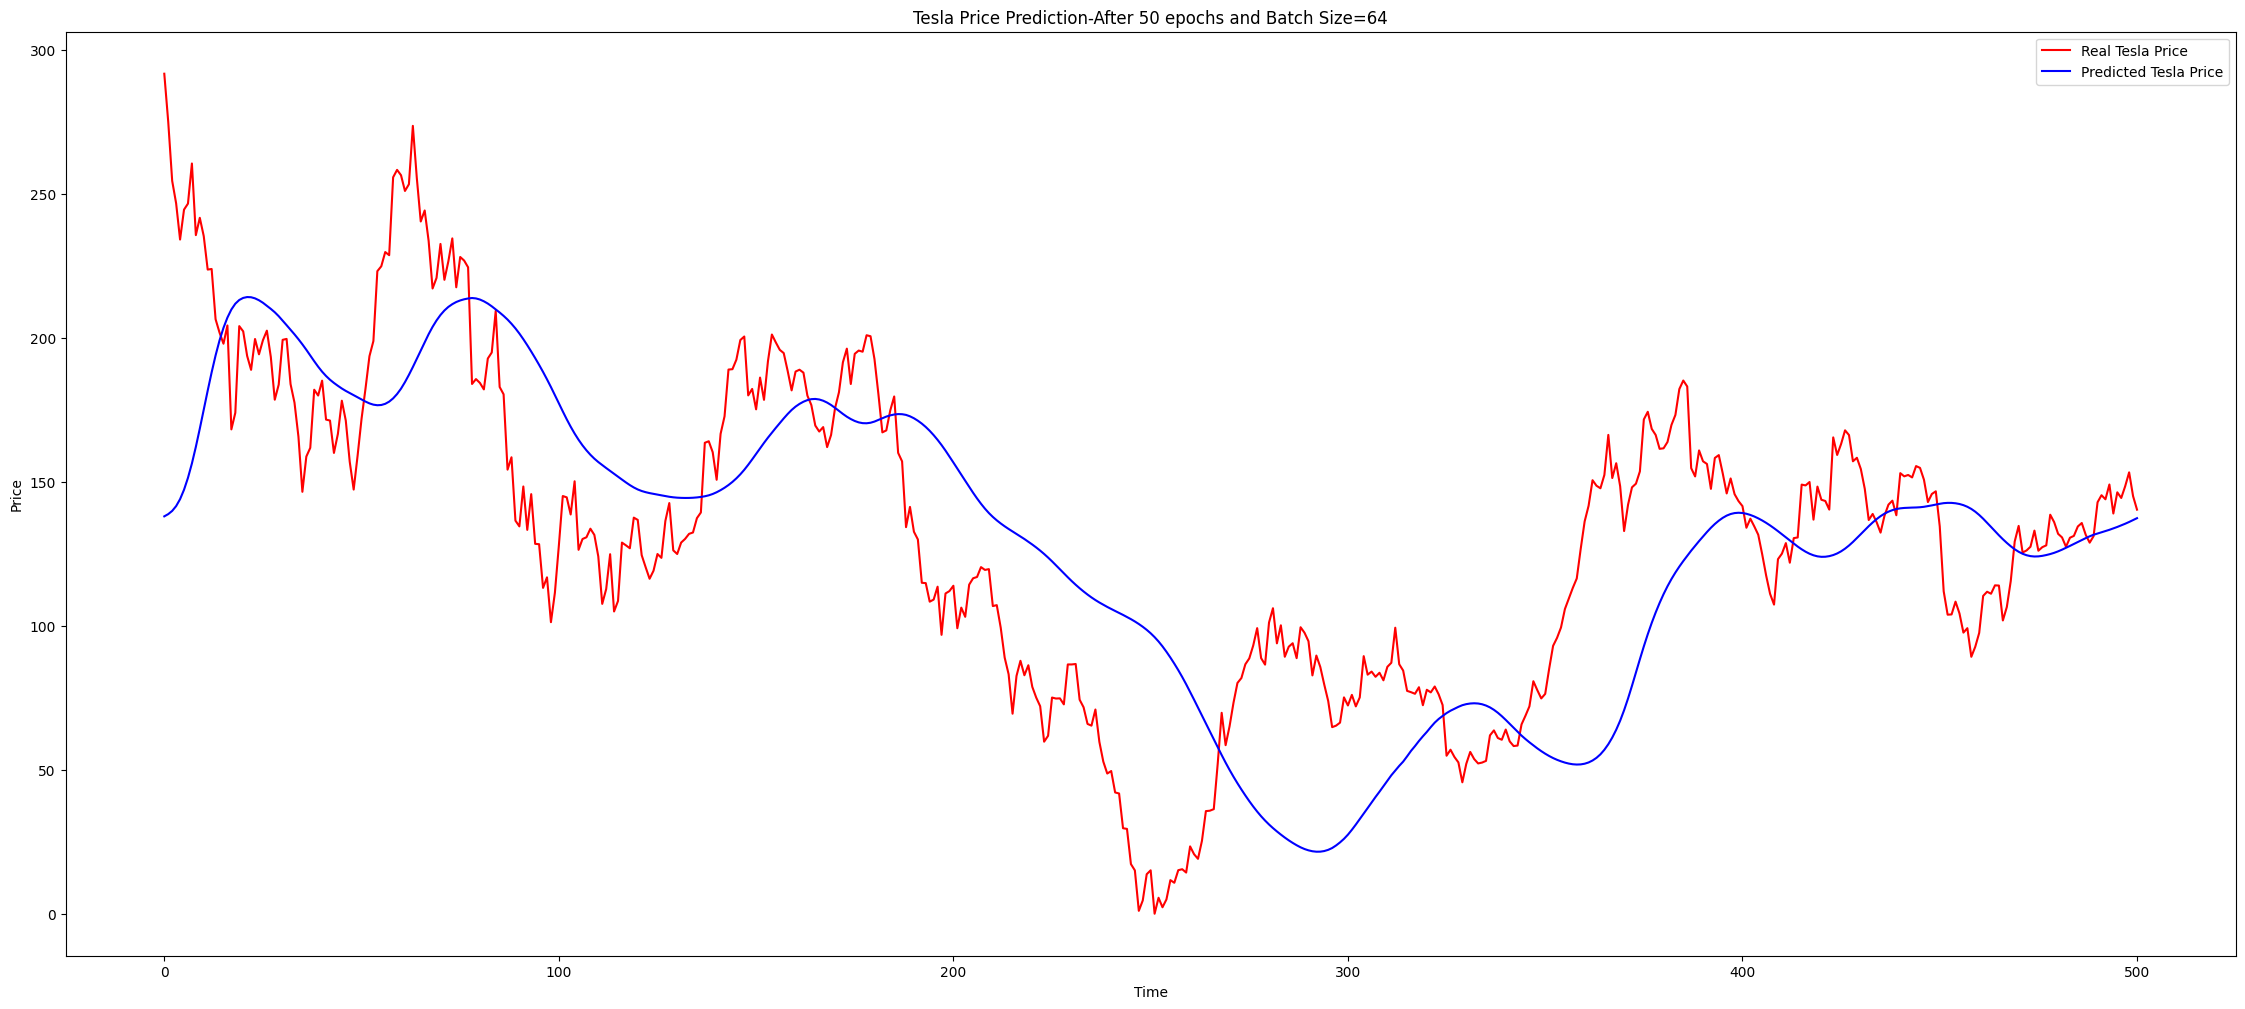

In [21]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Tesla Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Tesla Price')
plt.title('Tesla Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

df_result = pd.DataFrame()
df_result['true']= y_test
df_result['predicted']= y_pred

print(df_result)
print(f"mse: {mse:.2f}")
print(f"mae: {mae:.2f}")

# mse: 1122.20
# mae: 26.06

#mse 1451
#mae 31.42

#1232
#2810

           true   predicted
0    291.826668  138.053864
1    275.096657  138.827667
2    254.606667  139.938721
3    246.799996  141.610733
4    234.220009  144.022888
..          ...         ...
496  144.439995  134.910233
497  148.509987  135.487183
498  153.340004  136.097565
499  145.079995  136.752472
500  140.379998  137.418274

[501 rows x 2 columns]
mse: 1827.92
mae: 33.87
